In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

import qiskit
import numpy as np
from qiskit import *
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from math import sqrt, pi

from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import random_statevector, Statevector, partial_trace

In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
# Create QuantumCircuit with n_count counting qubits plus 4 qubits for U
#to act on n_count = 8 # number of counting qubits
n_count = 8
a = 13 # a variable that can be adjusted later
# The first 8-qubit register for storing x
qr1 = QuantumRegister(n_count, name="q1")
# The second 4-qubit register for storing f(x)
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
cr2 = ClassicalRegister(4, name="c2")
qc = QuantumCircuit(qr1, qr2, cr1, cr2)
# Initialize counting qubits in uniform superposition
for q in range(n_count):
    qc.h(q)
# And ancilla register in state |1>
qc.x(3+n_count)
# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q),
    [q] + [i+n_count for i in range(4)])
    
# qc.measure(qr1, cr1)
# qc.measure(qr2, cr2)

# simulator = Aer.get_backend('qasm_simulator')
# job = execute(qc, simulator, shots=100000)
# result = job.result()
# counts = result.get_counts()
# print(counts)
# plot_histogram(counts, bar_labels=False)

# aer_sim = Aer.get_backend('aer_simulator')
# t_qc = transpile(qc, aer_sim)
# qobj = assemble(t_qc)
# results = aer_sim.run(qobj).result()
# counts = results.get_counts()
# plot_histogram(counts, bar_labels=False)

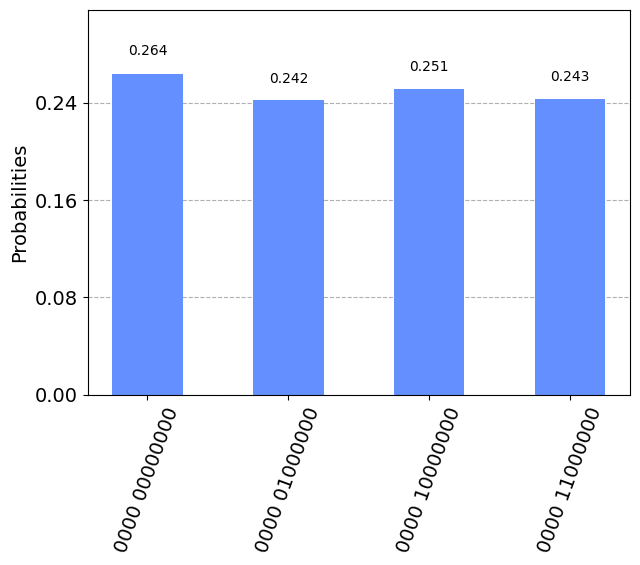

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))
# Measure circuit
qc.measure(range(n_count), range(n_count))

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [5]:
import pandas as pd
from fractions import Fraction
rows, measured_phases = [], []
for output in counts:
    decimal = int(output[5:], 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.75      3/4            4
2   0.25      1/4            4
3   0.50      1/2            2
